In [1]:
# IMPORTS
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from skimage.feature import hog
from skimage.feature import hog
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [48]:
from PIL import Image
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [2]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [3]:
#Cargar el dataset y ruta
DATA_DIR = r"./chest_xray/chest_xray"

def load_image_paths(data_dir):
    classes = ['NORMAL', 'PNEUMONIA']
    paths = []
    labels = []

    for split in ['train', 'val', 'test']:
        for cls in classes:
            folder = os.path.join(data_dir, split, cls)
            if not os.path.exists(folder):
                continue

            for p in glob(os.path.join(folder, '*.jpeg')) + \
                     glob(os.path.join(folder, '*.jpg')) + \
                     glob(os.path.join(folder, '*.png')):
                paths.append(p)
                labels.append((split, cls))
    return paths, labels

paths, labels = load_image_paths(DATA_DIR)

# 1. Análisis Exploratorio y Preprocesamiento

label
(train, PNEUMONIA)    3875
(train, NORMAL)       1341
(test, PNEUMONIA)      390
(test, NORMAL)         234
(val, NORMAL)            8
(val, PNEUMONIA)         8
Name: count, dtype: int64


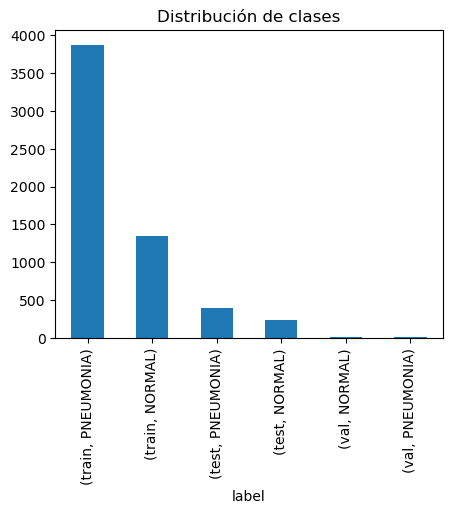

In [4]:
#Distribución de clases
df = pd.DataFrame({'path': paths, 'label': labels})
print(df['label'].value_counts())

df['label'].value_counts().plot(kind='bar', figsize=(5,4))
plt.title('Distribución de clases')
plt.show()

In [5]:
#Análisis de tamaño de imagenes
sizes = []
for p in paths:
    img = cv2.imread(p)
    h, w = img.shape[:2]
    sizes.append((w, h))

ws = [s[0] for s in sizes]
hs = [s[1] for s in sizes]

print("Promedio tamaño:", (np.mean(ws), np.mean(hs)))
print("Mediana tamaño:", (np.median(ws), np.median(hs)))

plt.figure(figsize=(10,4))
plt.hist(ws, bins=30, alpha=0.7, label='Ancho')
plt.hist(hs, bins=30, alpha=0.7, label='Alto')
plt.title('Distribución de tamaños originales')
plt.legend()
plt.show()

Promedio tamaño: (1327.880806010929, 970.6890368852459)
Mediana tamaño: (1281.0, 888.0)


Análisis: Dado que un gran número de las imágenes del dataset presentan tamaño diferente entre sí y de un tamaño grande (en promedio aproximado de 1327 x 970), se requiere aplicar un resize a la imágenes, esto con el fin de poder entrenar los modelos ya que requieren las entradas del mismo tamaño, además, con dimensiones como la del promedio, el tiempo y costo computacional sería muy grande. Si bien las resoluciones altas son importantes para las detección de características pequeñas, el estudio de Sabottke, C.F. & Spieler, B.M. (2020) sugieren que el tamaño se puede ajustar a resoluciones más bajas (Entre 256 x 256 y 448 x 448) sin perder mucha precisión en la detección de algunas características menos sutiles en las radiografías, sin embargo, el ajuste de la calidad dependerá de la necesidad específica de cada caso para encontrar un equilibrio entre capacidad de procesamiento y precisión del modelo.

Sabottke, C.F., & Spieler, B. M. (2020). The effect of image resolution on deep learning in radiography. Radiology: Artificial Intelligence, 2(1), e190015. https://doi.org/10.1148/ryai.2019190015

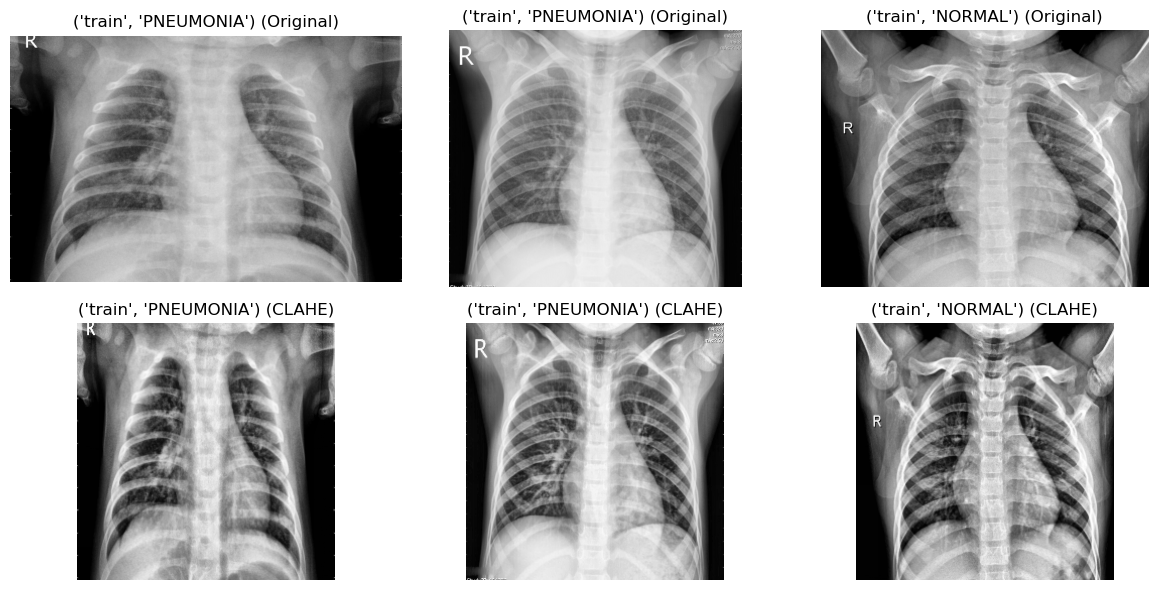

In [6]:
#Reescalado y CLAHE
IMG_SIZE = (256, 256)

def read_and_preprocess(path, img_size=IMG_SIZE, apply_clahe=True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"No se pudo leer: {path}")

    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)

    img = img.astype(np.float32) / 255.0
    return img

def show_examples(paths, labels, n=3):
    plt.figure(figsize=(12, 6))
    idxs = np.random.choice(range(len(paths)), n, replace=False)

    for i, idx in enumerate(idxs):
        img = cv2.imread(paths[idx], cv2.IMREAD_GRAYSCALE)
        plt.subplot(2, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{labels[idx]} (Original)")
        plt.axis('off')

        processed = read_and_preprocess(paths[idx], apply_clahe=True)
        plt.subplot(2, n, i+1+n)
        plt.imshow(processed, cmap='gray')
        plt.title(f"{labels[idx]} (CLAHE)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_examples(paths, labels, n=3)

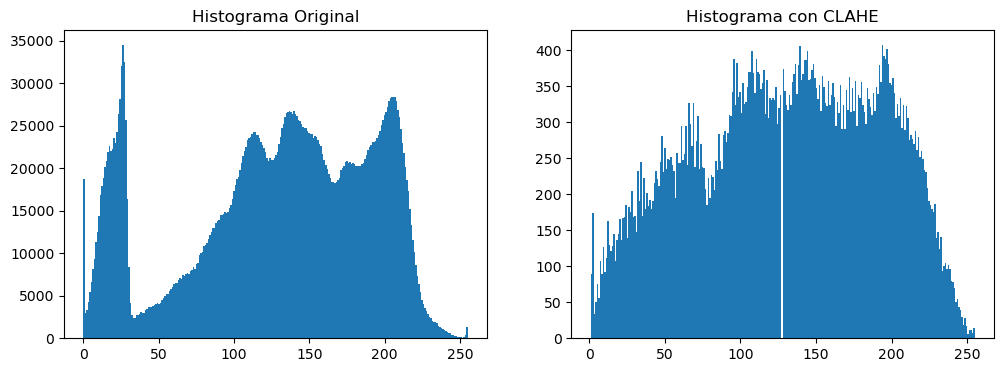

In [7]:
#Histogramas comparativos antes y después de CLAHE
sample_path = paths[0]

img_original = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
img_clahe = read_and_preprocess(sample_path, apply_clahe=True)
img_clahe_uint8 = (img_clahe * 255).astype('uint8')

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(img_original.flatten(), bins=256)
plt.title('Histograma Original')

plt.subplot(1,2,2)
plt.hist(img_clahe_uint8.flatten(), bins=256)
plt.title('Histograma con CLAHE')

plt.show()

CLAHE (Contrast-Limited Adaptive Histogram Equalization) es una variación de la Ecualización Adaptativa del Histograma (AHE) expuesta por Pizer, S. M. et al. (1987). con el objetivo de mejorar el contraste por regiones dentro de las imágenes. Al añadir limite a la altura del histograma, restringe el exceso de contraste en zonas homogéneas y evita ruidos excesivos.
Como observamos con nuestro ejemplo antes y después de CLAHE, el histograma se distribuye de forma más homogenea en todo el rango de intensidades mejorando el contraste y evitando picos exagerados, lo que permite obtener imagenes con contraste local más detallado sin amplificar ruido.

Pizer, S. M., Amburn, E. P., Austin, J. D., Cromartie, R., Geselowitz, A., Greer, T., ter Haar Romeny, B., Zimmerman, J. B., & Zuiderveld, K. (1987). Adaptive histogram equalization and its variations. Computer Vision, Graphics, and Image Processing, 39(3), 355–368. https://doi.org/10.1016/S0734-189X(87)80186-X

# 2. Extracción de Descriptores Clásicos

## 2.1. Descriptores de forma 

In [8]:
#Carga de imagen
img = read_and_preprocess(sample_path)

#Función imagen muestra
def ver_img_muestra(img):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Imagen preprocesada")
    plt.imshow(img, cmap='gray')
    plt.axis("off")


### 2.2.1. HOG

In [9]:
def descriptor_hog(img, pixels_per_cell=(16,16), orientations=9):
    hog_vec, hog_img = hog(
        (img*255).astype("uint8"),
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=(2,2),
        visualize=True
    )
    return hog_vec, hog_img

def grid_hog_variations(img):
    
    bins_list = [12, 9, 6]
    cells_list = [(8,8), (16,16), (32,32)]

    fig, axs = plt.subplots(3, 3, figsize=(12,12))
    fig.suptitle("Variaciones del Descriptor HOG", fontsize=16)

    # variar bins
    for i, b in enumerate(bins_list):
        _, vis = descriptor_hog(img, pixels_per_cell=(16,16), orientations=b)
        axs[0, i].imshow(vis, cmap='inferno')
        axs[0, i].set_title(f"cell={16,16}, bins={b}")
        axs[0, i].axis("off")

    # variar tamaño de celda
    for i, c in enumerate(cells_list):
        _, vis = descriptor_hog(img, pixels_per_cell=c, orientations=9)
        axs[1, i].imshow(vis, cmap='inferno')
        axs[1, i].set_title(f"cell={c}, bins={9}")
        axs[1, i].axis("off")

    # combinaciones

    combos = list(zip(cells_list, bins_list)) 
    for i, (c, b) in enumerate(combos):
        _, vis = descriptor_hog(img, pixels_per_cell=c, orientations=b)
        axs[2, i].imshow(vis, cmap='inferno')
        axs[2, i].set_title(f"cell={c}, bins={b}")
        axs[2, i].axis("off")

    plt.tight_layout()
    plt.show()

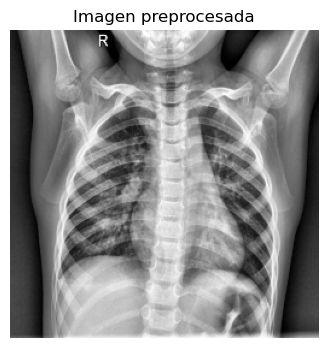

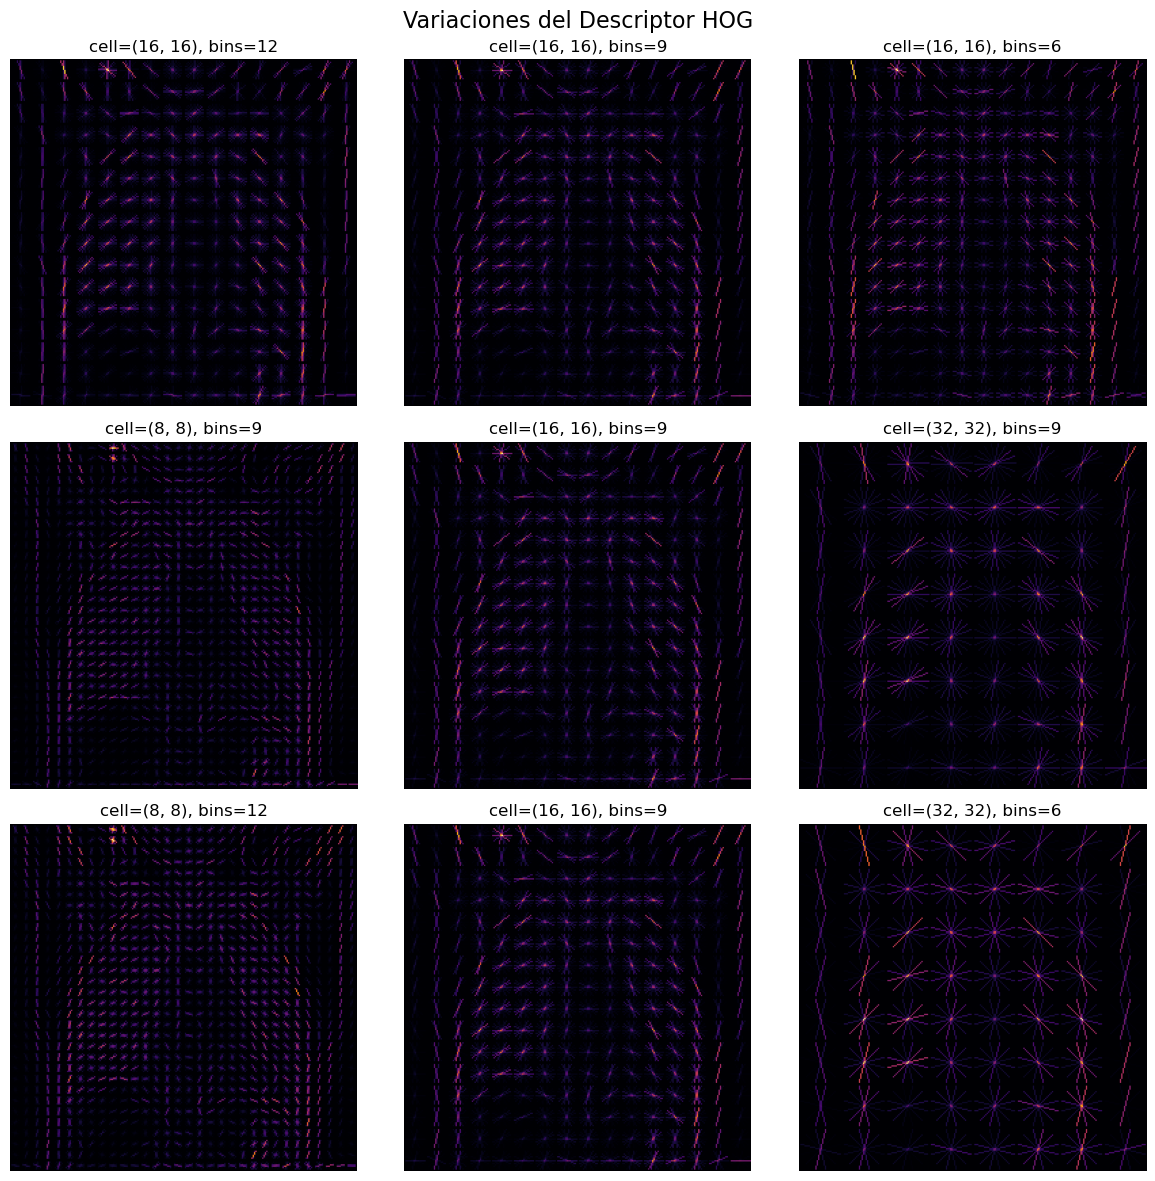

In [10]:
ver_img_muestra(img)
grid_hog_variations(img)

Con mayor número de bins podemos observar mayor detalle de la orientación de los bordes, con una imagen más limpia. Respecto a la variación en el tamaño de las celdas, entre más pequeña la celda, mayor detalle en la visual de las formas y contornos, entre más grande desaparece la estructura y solo capta detalles globales.

Al combinar celdas pequeñas y muchos bins, obtenemos una imagen muy detallada y semejante a la imagen original. Por el contrario, con pocos bins y celdas grandes, el descriptor muestra solo detalles globales. 

### 2.2.2. Momentos de Hu

In [11]:
def descriptor_hu(img):
    img_u8 = (img*255).astype("uint8")
    m = cv2.moments(img_u8)
    hu = cv2.HuMoments(m).flatten()
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-12)
    return hu_log

In [12]:
def test_invariances(img):
    # Traslación
    M = np.float32([[1, 0, 50], [0, 1, 50]])
    shift = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    print("\nTraslación:", descriptor_hu(shift))

    # Rotación
    M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), 90, 1)
    rot = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    print("\nRotación 90°:", descriptor_hu(rot))

    # Escalado
    scale = cv2.resize(img, None, fx=0.5, fy=0.5)
    print("\nEscalado 0.5x:", descriptor_hu(scale))

In [13]:
print("\n7 momentos HU: ", descriptor_hu(img))
print(test_invariances(img))


7 momentos HU:  [  2.93815484   7.51971826  10.9446065   11.47334931 -12.
  11.99986037 -12.        ]

Traslación: [  2.93508043   7.85021536  11.50842868  11.17077895  12.
 -11.99981262  12.        ]

Rotación 90°: [  2.93834065   7.5070706   10.93151146  11.4731752  -12.
  11.99985275 -12.        ]

Escalado 0.5x: [  2.93707086   7.51510495  10.93927093  11.46920671 -12.
  11.99985758 -12.        ]
None


Los 7 momentos de Hu son valores numéricos que representan un patrón o figuras dentro de las imágenes y no cambian si sufren traslación, rotación o escalado, lo cual permite reconocer formas sin depender la ubicación u orientación. (Hu, M.-K., 1962).

Para nuestro ejemplo, los momentos Hu de la imagen muestran cambios muy pequeños en la traslación, rotación y escalado, dando evidencia de que, posterior a las transformaciones, los momentos fueron casi idénticos.

Hu, M.-K. (1962). Visual pattern recognition by moment invariants. IRE Transactions on Information Theory, 8(2), 179–187. https://doi.org/10.1109/TIT.1962.1057692

### 2.2.3. Descriptor de contorno

In [14]:
def segmentar(img):
    img_u8 = (img*255).astype("uint8")
    _, mask = cv2.threshold(img_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

def descriptor_contorno(img):
    mask = segmentar(img)
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(cnts) == 0:
        return {"area":0, "perimetro":0, "circularidad":0, "excentricidad":0}

    cnt = max(cnts, key=cv2.contourArea)

    area = cv2.contourArea(cnt)
    perimetro = cv2.arcLength(cnt, True)
    circularidad = 4 * np.pi * area / (perimetro**2 + 1e-12)

    # Excentricidad vía elipse ajustada
    if len(cnt) >= 5:
        (_, _), (MA, ma), _ = cv2.fitEllipse(cnt)
        excentricidad = np.sqrt(1 - (MA/ma)**2)
    else:
        excentricidad = np.nan

    return {
        "area": area,
        "perimetro": perimetro,
        "circularidad": circularidad,
        "excentricidad": excentricidad
    }

def show_contour(img):
    mask = segmentar(img)
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt = max(cnts, key=cv2.contourArea)

    img_draw = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img_draw, [cnt], -1, (255,0,0), 2)

    plt.figure(figsize=(5,5))
    plt.title("Contorno Detectado")
    plt.imshow(img_draw)
    plt.axis("off")
    plt.show()


In [15]:
show_contour(img)
descriptor_contorno(img)

{'area': 42197.5,
 'perimetro': 1473.9280548095703,
 'circularidad': 0.24408664345324074,
 'excentricidad': 0.6375004257850608}

### 2.2.4. Descriptores de Fourier

In [16]:
def descriptor_fourier(img, n_coeff=20):
    mask = segmentar(img)
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(cnts) == 0:
        return np.zeros(n_coeff)

    cnt = max(cnts, key=len).squeeze()
    contorno = cnt[:,0] + 1j*cnt[:,1]

    fd = np.fft.fft(contorno)

    # Normalización (invarianza a escala)
    fd_norm = fd / (np.abs(fd[1]) + 1e-9)

    return fd_norm[:n_coeff]

def plot_fourier(fd):
    plt.figure(figsize=(7,4))
    plt.plot(np.abs(fd))
    plt.title("Fourier Descriptors — Magnitudes")
    plt.grid(True)
    plt.show()


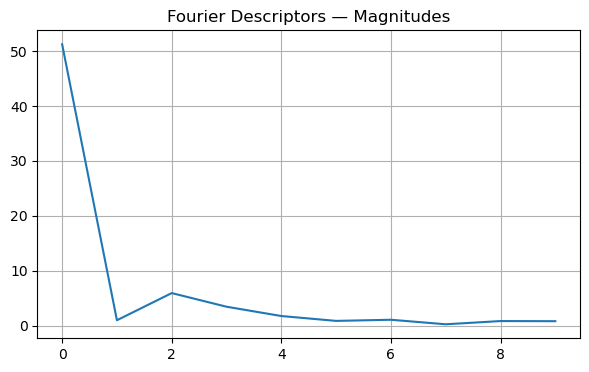

FD Shape: (10,)


In [17]:
fd = descriptor_fourier(img, n_coeff=10)
plot_fourier(fd)
print("FD Shape:", fd.shape)

Los descriptores de fourier señalados en Zahn, C.T., & Roskies, R.Z. (1972), son una representación numérica del contorno de un objeto usando una serie de fourier. Los coeficientes iniciales representan propiedades de la forma y los de orden superior representan detalles más finos.

Para nuestro ejemplo, los coeficientes de fourier muestran un valor alto inicialmente indicando una forma grande, después cae a valores cercanos a cero por lo que el objeto tiene forma sencilla y no posee curvaturas demasiado complejas.
El coeficiente 2 sube un poco, indicando que tiene forma elíptica o alargada. Los coeficientes restantes tienden a 0, por lo que se puede inferir que la figura no tiene detalles finos o esquinas pronunciadas.

Zahn, C.T., & Roskies, R.Z. (1972). Fourier descriptors for plane closed curves. IEEE Transactions on Computers, C-21(3), 269–281. https://doi.org/10.1109/TC.1972.5008949

## 2.2. Descriptores de textura

### 2.2.1. Local Binary Patterns (LBP)

In [18]:
from skimage.feature import local_binary_pattern

def descriptor_lbp(img, P=8, R=1):
    lbp = local_binary_pattern(img, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(P + 3), density=True)
    return lbp, hist

def show_lbp_img(img):
    configs = [(8,1), (16,1), (24,1),
               (8,1), (8,2), (8,3),
               (8,1), (16,2), (24,3)]

    plt.figure(figsize=(12,12))
    
    for i, (P,R) in enumerate(configs):
        lbp, hist = descriptor_lbp(img, P, R)
        # Imagen LBP
        plt.subplot(3,3,i+1)
        plt.imshow(lbp, cmap='inferno')
        plt.title(f"LBP Image\nP={P}, R={R}")
        plt.axis("off")

    plt.tight_layout()   
    plt.show()

def show_lbp_hist(img):
    configs = [(8,1), (16,1), (24,1),
               (8,1), (8,2), (8,3),
               (8,1), (16,2), (24,3)]

    plt.figure(figsize=(12,12))

    for i, (P,R) in enumerate(configs):
        lbp, hist = descriptor_lbp(img, P, R)
        # Histograma
        plt.subplot(3,3,i+1)
        plt.bar(np.arange(len(hist)), hist)
        plt.title(f"Histograma\nP={P}, R={R}")
        plt.xlabel("Patrones LBP")
        plt.ylabel("Frecuencia")

    plt.tight_layout()   
    plt.show()


C:\Users\juanj\Anaconda\envs\pytorch-gpu\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


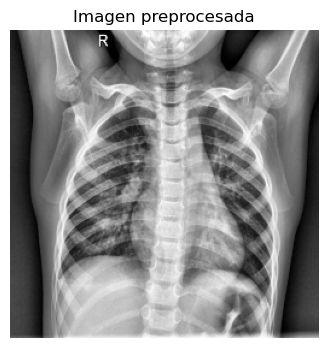

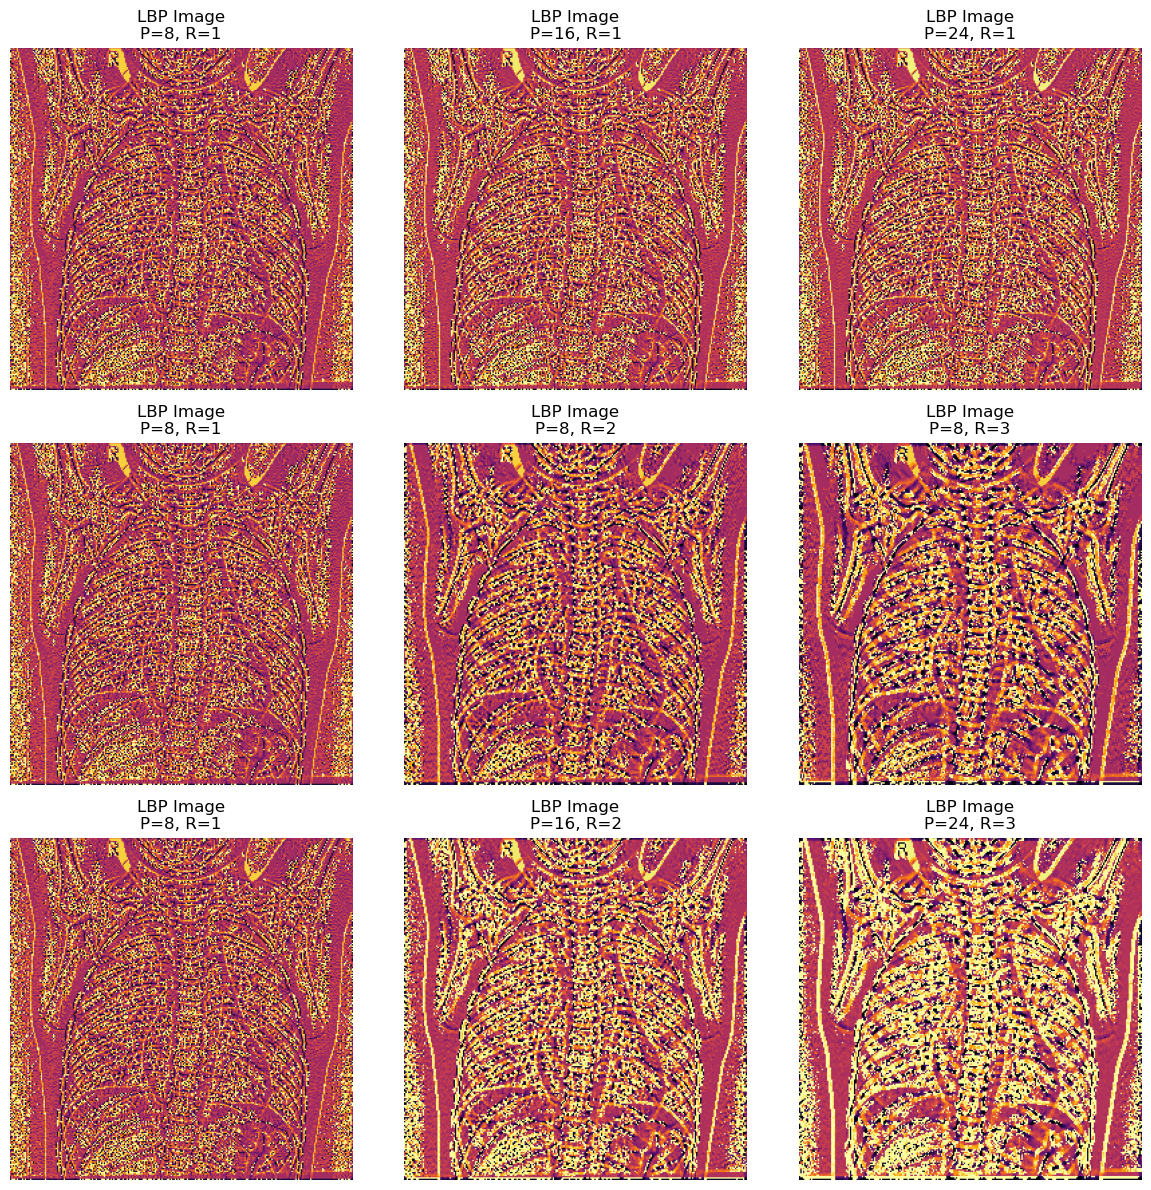

In [19]:
ver_img_muestra(img)
show_lbp_img(img)
show_lbp_hist(img)

El trabajo de Ojala et al.(2002) hace una aproximación a la clasificación de texturas utilizando patrones binarios locales (LBP). El operador LBP deriva de la distribución de los valores de gris de un pixel central con el conjunto de sus vecinos, haciendo uso de los parámetros P (puntos) con el número de sus pixeles vecinos, permitiendo entre mayor el valor, capturar patrones de textura más finos; y R (radio) que es el radio del círculo sobre sobre el cual se muestrean los P vecinos, por lo que un R más pequeño implica texturas finas (patrones cercanos) y si incrementa toma texturas más gruesas con patrones más grandes o repetitivos a mayores distancias.
Para nuestro ejemplo, observamos que al incrementar R las lineas la estructura ósea se revela más gruesas y visibles, en el histograma observamos una variación en las frecuencias al capturar diferentes estructuras de textura. Con un P mayor, la imagen se vuelve más ruidosa buscando un mayor número de patrones, y esto se observa en los histogramas al obtener un mayor número de contenedores (P). 

Ojala, T., Pietikäinen, M., & Mäenpää, T. (2002). Multiresolution gray-scale and rotation invariant texture classification with Local Binary Patterns. IEEE Transactions on Pattern Analysis and Machine Intelligence, 24(7), 971–987. http://vision.stanford.edu/teaching/cs231b_spring1415/papers/lbp.pdf


### 2.2.2. Gray Level Co-occurrence Matrix (GLCM)

In [20]:
from skimage.feature import graycomatrix, graycoprops

def descriptor_glcm(img, distances=[1], angles=[0], levels=256,
                    props=['contrast', 'correlation', 'energy', 'homogeneity']):
    img_u8 = (img * 255).astype('uint8')

    glcm = graycomatrix(
        img_u8,
        distances=distances,
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True
    )

    feats = []
    for p in props:
        vals = graycoprops(glcm, p)
        feats.append(vals.mean())

    return np.array(feats)

In [21]:
descriptor_glcm(img)

array([1.89981464e+02, 9.74237573e-01, 1.31490274e-02, 1.59005882e-01])

### 2.2.3. Filtros de Gabor

In [22]:
from skimage.filters import gabor

def descriptor_gabor(img, freqs=[0.1, 0.2, 0.3], thetas=[0, np.pi/4, np.pi/2]):
    feats = []
    for f in freqs:
        for t in thetas:
            real, imag = gabor(img, frequency=f, theta=t)
            feats.append(real.mean())
            feats.append(real.std())
    return np.array(feats)


In [23]:
descriptor_gabor(img)

array([0.00049103, 0.01105912, 0.00029817, 0.00933322, 0.00049103,
       0.00953856, 0.00073169, 0.0072307 , 0.00042584, 0.00575609,
       0.00073169, 0.00590754, 0.00085209, 0.00619242, 0.00058005,
       0.00480077, 0.00085209, 0.00501808], dtype=float32)

### 2.2.4. Estadísticas de primer orden

In [24]:
from scipy.stats import skew, kurtosis
from skimage.measure import shannon_entropy

def first_order_stats(img):
    img_f = img.astype(np.float32).ravel()
    feats = {
        "mean": img_f.mean(),
        "var": img_f.var(),
        "skew": skew(img_f),
        "kurtosis": kurtosis(img_f),
        "entropy": shannon_entropy(img)
    }
    return feats


In [25]:
first_order_stats(img)

{'mean': 0.51024663,
 'var': 0.056878112,
 'skew': -0.1621051267964758,
 'kurtosis': -0.9509974196331576,
 'entropy': 7.852644766661649}

# 3. Clasificación con Descriptores Clásicos

In [26]:
#Separación en train, val y test

paths_train = [p for p, (split, cls) in zip(paths, labels) if split == 'train']
labels_train = [cls for split, cls in labels if split == 'train']

paths_val = [p for p, (split, cls) in zip(paths, labels) if split == 'val']
labels_val = [cls for split, cls in labels if split == 'val']

paths_test = [p for p, (split, cls) in zip(paths, labels) if split == 'test']
labels_test = [cls for split, cls in labels if split == 'test']

# Etiquetas de texto a números (NORMAL=0, PNEUMONIA=1)
label_map = {'NORMAL': 0, 'PNEUMONIA': 1}

y_train = np.array([label_map[l] for l in labels_train])
y_val = np.array([label_map[l] for l in labels_val])
y_test = np.array([label_map[l] for l in labels_test])


In [27]:
print("Train:", len(paths_train), len(labels_train))
print("Val:", len(paths_val), len(labels_val))
print("Test:", len(paths_test), len(labels_test))


Train: 5216 5216
Val: 16 16
Test: 624 624


## 3.1. Matriz de características

In [28]:
def extract_features_all(img, descriptor_hog, descriptor_hu, descriptor_fourier,
                         descriptor_lbp, descriptor_glcm, descriptor_gabor):

    img_u8 = (img * 255).astype("uint8")
    feats = []

    # HOG
    hog_vec, _ = descriptor_hog(img)
    feats.extend(hog_vec.flatten().tolist())

    # Hu
    hu = descriptor_hu(img)
    feats.extend(hu.tolist())

    # Fourier
    coeff = descriptor_fourier(img)
    feats.extend(np.abs(coeff).tolist())

    # LBP
    _, lbp_hist = descriptor_lbp(img, P=8, R=2)
    feats.extend(lbp_hist.flatten().tolist())

    # GLCM
    glcm_feats = descriptor_glcm(img_u8)
    feats.extend(glcm_feats.tolist())

    # Gabor
    gabor_feats = descriptor_gabor(img)
    feats.extend(np.array(gabor_feats, dtype=np.float32).flatten().tolist())

    return np.array(feats, dtype=np.float32)



In [29]:
def build_feature_matrix(paths, descriptor_hog, descriptor_hu, descriptor_fourier,
                         descriptor_lbp, descriptor_glcm, descriptor_gabor):

    X = []

    for p in tqdm(paths):
        img = read_and_preprocess(p)
        if img is None:
            print(f"Imagen inválida: {p}")
            continue

        try:
            features = extract_features_all(
                img,
                descriptor_hog, descriptor_hu, descriptor_fourier,
                descriptor_lbp, descriptor_glcm, descriptor_gabor
            )

            if features.ndim != 1:
                print(f"Vector con shape raro en {p}: {features.shape}")
                continue

            X.append(features)

        except Exception as e:
            print(f"Error al procesar {p}: {e}")

    return np.array(X, dtype=np.float32)


In [30]:
X_train = build_feature_matrix(
    paths_train,
    descriptor_hog, descriptor_hu, descriptor_fourier,
    descriptor_lbp, descriptor_glcm, descriptor_gabor
)

X_val = build_feature_matrix(
    paths_val,
    descriptor_hog, descriptor_hu, descriptor_fourier,
    descriptor_lbp, descriptor_glcm, descriptor_gabor
)

X_test = build_feature_matrix(
    paths_test,
    descriptor_hog, descriptor_hu, descriptor_fourier,
    descriptor_lbp, descriptor_glcm, descriptor_gabor
)


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [03:33<00:00,  2.92it/s]


In [31]:
y_train = np.array([label_map[l] for l in labels_train], dtype=np.int32)
y_val   = np.array([label_map[l] for l in labels_val], dtype=np.int32)
y_test  = np.array([label_map[l] for l in labels_test], dtype=np.int32)

### 3.2. Normalización

In [32]:
#Normalización
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

### 3.3. Reducción de dimensionalidad

In [33]:
#Reducción de dimensionalidad
from sklearn.decomposition import PCA

# Reducir la dimensionalidad 
pca = PCA(0.95)

# PCA en el conjunto de entrenamiento normalizado
pca.fit(X_train_norm)

# Aplicar la transformación a los tres conjuntos
X_train_pca = pca.transform(X_train_norm)
X_val_pca = pca.transform(X_val_norm)
X_test_pca = pca.transform(X_test_norm)

### 3.4. Entrenamiento y evaluación de múltiples clasificadores

In [34]:
# Entrenamiento y evaluación en val y test
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Evaluación de modelos
def evaluate_model(name, clf, X_train, y_train, X_val, y_val, X_test, y_test):
    print("-------------------------------------")
    print("\nModelo:", name)

    clf.fit(X_train, y_train)

    # Validation
    pred_val = clf.predict(X_val)
    acc_val = accuracy_score(y_val, pred_val)
    f1_val  = f1_score(y_val, pred_val)
    print(f"Val Accuracy={acc_val:.4f}  F1={f1_val:.4f}")

    # Test
    pred_test = clf.predict(X_test)
    acc_test = accuracy_score(y_test, pred_test)
    f1_test  = f1_score(y_test, pred_test)
    print(f"TEST Accuracy={acc_test:.4f}  F1={f1_test:.4f}")

    print("Classification report TEST:")
    print(classification_report(y_test, pred_test))

    print("Confusion matrix TEST:")
    print(confusion_matrix(y_test, pred_test))

    return clf


In [35]:
# Modelos a entrenar
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


models = {
    "SVM-linear": SVC(kernel="linear", probability=True),
    "SVM-RBF": SVC(kernel="rbf", probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=300),
    "kNN-5": KNeighborsClassifier(n_neighbors=5),
    "LogReg": LogisticRegression(max_iter=1000)
}


In [36]:
# entrenamiento del modelo
trained_models = {}

for name, clf in models.items():
    trained_models[name] = evaluate_model(name, clf,
                                          X_train_pca, y_train,
                                          X_val_pca, y_val,
                                          X_test_pca, y_test)

-------------------------------------

Modelo: SVM-linear
Val Accuracy=0.9375  F1=0.9412
TEST Accuracy=0.7420  F1=0.8282
Classification report TEST:
              precision    recall  f1-score   support

           0       0.97      0.32      0.48       234
           1       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.74      0.70       624

Confusion matrix TEST:
[[ 75 159]
 [  2 388]]
-------------------------------------

Modelo: SVM-RBF
Val Accuracy=0.9375  F1=0.9412
TEST Accuracy=0.7484  F1=0.8317
Classification report TEST:
              precision    recall  f1-score   support

           0       0.98      0.34      0.50       234
           1       0.71      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.67      0.67       624
weighted avg       0.81      0.75      0.71       624

Confu

### 3.5. Validación cruzada

In [37]:
from sklearn.model_selection import cross_val_score

for name, clf in models.items():
    scores = cross_val_score(clf, X_train_pca, y_train, cv=5, scoring="f1")
    print(f"\n{name} | CV F1 promedio: {scores.mean():.4f}  (+/- {scores.std():.4f})")



SVM-linear | CV F1 promedio: 0.9828  (+/- 0.0045)

SVM-RBF | CV F1 promedio: 0.9846  (+/- 0.0058)

RandomForest | CV F1 promedio: 0.8570  (+/- 0.0018)

kNN-5 | CV F1 promedio: 0.9726  (+/- 0.0068)

LogReg | CV F1 promedio: 0.9809  (+/- 0.0058)


### 3.6. Análisis de importancia de features

In [38]:
# RandomForest
rf = trained_models["RandomForest"]

importances = rf.feature_importances_

# Mostrar top 20
indices = np.argsort(importances)[-20:]

print("\nTop 20 features más importantes (Random Forest):")
for i in indices[::-1]:
    print(f"Feature {i}: {importances[i]:.4f}")



Top 20 features más importantes (Random Forest):
Feature 1: 0.0565
Feature 0: 0.0541
Feature 6: 0.0253
Feature 2: 0.0134
Feature 4: 0.0104
Feature 19: 0.0076
Feature 3: 0.0049
Feature 20: 0.0039
Feature 5: 0.0037
Feature 8: 0.0037
Feature 14: 0.0034
Feature 7: 0.0032
Feature 11: 0.0027
Feature 18: 0.0027
Feature 23: 0.0027
Feature 13: 0.0026
Feature 22: 0.0026
Feature 15: 0.0020
Feature 27: 0.0020
Feature 16: 0.0019


In [39]:
# SVM 
svm_lin = trained_models["SVM-linear"]
coefs = np.abs(svm_lin.coef_)[0]

indices = np.argsort(coefs)[-20:]

print("\nTop 20 features más importantes (SVM Linear):")
for i in indices[::-1]:
    print(f"Feature {i}: {coefs[i]:.4f}")


Top 20 features más importantes (SVM Linear):
Feature 6: 0.0721
Feature 1: 0.0703
Feature 19: 0.0614
Feature 0: 0.0593
Feature 4: 0.0455
Feature 139: 0.0438
Feature 2: 0.0436
Feature 168: 0.0380
Feature 23: 0.0338
Feature 426: 0.0332
Feature 36: 0.0316
Feature 423: 0.0305
Feature 233: 0.0303
Feature 317: 0.0301
Feature 20: 0.0293
Feature 14: 0.0288
Feature 257: 0.0288
Feature 253: 0.0285
Feature 134: 0.0285
Feature 870: 0.0284


In [40]:
print(trained_models.keys())

dict_keys(['SVM-linear', 'SVM-RBF', 'RandomForest', 'kNN-5', 'LogReg'])


In [41]:
# Regresión logística
lr = trained_models["LogReg"]
coefs = np.abs(lr.coef_)[0]

indices = np.argsort(coefs)[-20:]

print("\nTop 20 features más importantes (Logistic Regression):")
for i in indices[::-1]:
    print(f"Feature {i}: {coefs[i]:.4f}")


Top 20 features más importantes (Logistic Regression):
Feature 6: 0.4319
Feature 1: 0.4014
Feature 19: 0.3869
Feature 0: 0.3344
Feature 4: 0.2659
Feature 168: 0.2483
Feature 139: 0.2426
Feature 2: 0.2423
Feature 23: 0.2270
Feature 20: 0.2234
Feature 870: 0.2111
Feature 426: 0.1980
Feature 128: 0.1969
Feature 36: 0.1874
Feature 423: 0.1844
Feature 27: 0.1843
Feature 1148: 0.1835
Feature 26: 0.1828
Feature 233: 0.1824
Feature 332: 0.1802


## Construcción de la CNN

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU()
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return torch.sigmoid(x)
 


class ChestXrayDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        self.label_map = {"NORMAL": 0.0, "PNEUMONIA": 1.0}

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")
        img = transform(img)  
        
        label_str = self.labels[idx]
        label = self.label_map[label_str]

        return img, torch.tensor(label, dtype=torch.float32)




## Entrenamiento CNN

In [55]:
def train_cnn(model, train_loader, val_loader, labels_train, epochs=10, lr=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Calcular pesos de clase
    classes = np.unique(labels_train)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=labels_train
    )
    
    # Convertir a tensor de PyTorch
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    print("Pesos de clase:", class_weights_tensor)
    
    # Calcular pos_weight para BCEWithLogitsLoss
    # Asumimos: clase 0 = NORMAL, clase 1 = PNEUMONIA
    pos_weight = class_weights_tensor[1] / class_weights_tensor[0]
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)  # Asegurar forma [batch, 1]

            optimizer.zero_grad()
            preds = model(x)  # Salida sin sigmoid (logits)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

In [56]:
def evaluate_model_on_test(clf, X_test, y_test):
    y_pred = clf.predict(X_test)

    if hasattr(clf, 'predict_proba'):
        y_prob = clf.predict_proba(X_test)[:, 1]
    else:
        y_prob = clf.decision_function(X_test)

    print(classification_report(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    print("AUC:", auc)

    return fpr, tpr, auc


In [66]:
# Crear datasets
from PIL import Image

train_dataset = ChestXrayDataset(paths_train, labels_train)
val_dataset = ChestXrayDataset(paths_val, labels_val)
test_dataset = ChestXrayDataset(paths_test, labels_test)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("\nEntrenando CNN...\n")
for epoch in range(50):
    model.train()
    loss_total = 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds,y)
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    print(f"Epoch {epoch+1}/5 — Loss: {loss_total/len(train_loader):.4f}")



Entrenando CNN...

Epoch 1/5 — Loss: 0.5947
Epoch 2/5 — Loss: 0.5841
Epoch 3/5 — Loss: 0.5699
Epoch 4/5 — Loss: 0.5416
Epoch 5/5 — Loss: 0.4704
Epoch 6/5 — Loss: 0.4055
Epoch 7/5 — Loss: 0.3588
Epoch 8/5 — Loss: 0.3355
Epoch 9/5 — Loss: 0.3275
Epoch 10/5 — Loss: 0.3213
Epoch 11/5 — Loss: 0.3157
Epoch 12/5 — Loss: 0.3046
Epoch 13/5 — Loss: 0.3044
Epoch 14/5 — Loss: 0.2911
Epoch 15/5 — Loss: 0.3004
Epoch 16/5 — Loss: 0.2963
Epoch 17/5 — Loss: 0.2905
Epoch 18/5 — Loss: 0.2822
Epoch 19/5 — Loss: 0.2840
Epoch 20/5 — Loss: 0.2904
Epoch 21/5 — Loss: 0.2830
Epoch 22/5 — Loss: 0.2802
Epoch 23/5 — Loss: 0.2748
Epoch 24/5 — Loss: 0.2720
Epoch 25/5 — Loss: 0.2740
Epoch 26/5 — Loss: 0.2787
Epoch 27/5 — Loss: 0.2747
Epoch 28/5 — Loss: 0.2677
Epoch 29/5 — Loss: 0.2634
Epoch 30/5 — Loss: 0.2679
Epoch 31/5 — Loss: 0.2574
Epoch 32/5 — Loss: 0.2581
Epoch 33/5 — Loss: 0.2597
Epoch 34/5 — Loss: 0.2605
Epoch 35/5 — Loss: 0.2523
Epoch 36/5 — Loss: 0.2617
Epoch 37/5 — Loss: 0.2557
Epoch 38/5 — Loss: 0.2505
E

Device: cuda

=== METRICAS ===
Accuracy: 0.6875
F1: 0.7619

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      NORMAL       1.00      0.38      0.55         8
   PNEUMONIA       0.62      1.00      0.76         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16



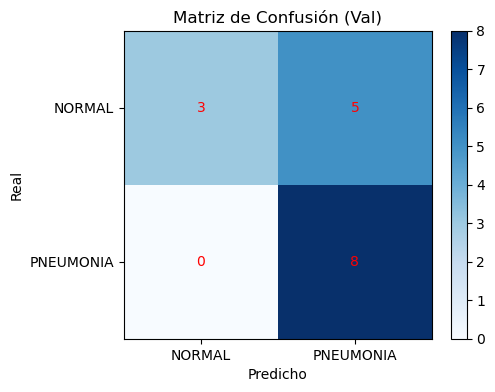

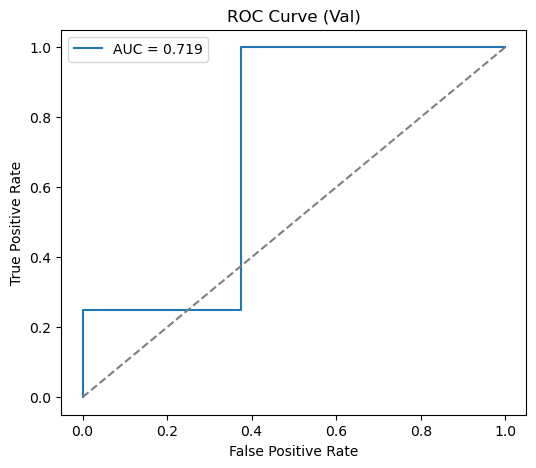

AUC: 0.7188


Modelo guardado en: modelo_simple_cnn.pt


In [67]:
# CELDA: Evaluación completa (pegar y ejecutar)
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, f1_score
import matplotlib.pyplot as plt
import random

# 1) Device (define GPU si está, si no CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2) Asegúrate de que el modelo esté en el device
model = model.to(device)
model.eval()

# 3) Recolectar predicciones en el conjunto de validación
y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device, dtype=torch.float32)
        # labels pueden venir como float tensor; asegurar dtype y forma
        labels_cpu = labels.cpu().numpy().astype(int)
        outputs = model(images)                  # salida sigmoid ya en forward
        probs = outputs.detach().cpu().numpy().flatten()
        preds = (probs > 0.5).astype(int)

        y_true.extend(labels_cpu.tolist())
        y_pred.extend(preds.tolist())
        y_prob.extend(probs.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# 4) Métricas
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print("\n=== METRICAS ===")
print(f"Accuracy: {acc:.4f}")
print(f"F1: {f1:.4f}")
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=["NORMAL","PNEUMONIA"]))

# 5) Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues", interpolation='nearest')
plt.title("Matriz de Confusión (Val)")
plt.colorbar()
plt.xticks([0,1], ["NORMAL","PNEUMONIA"])
plt.yticks([0,1], ["NORMAL","PNEUMONIA"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="red")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# 6) ROC y AUC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Val)")
plt.legend()
plt.show()
print(f"AUC: {roc_auc:.4f}")

# 7) Mostrar ejemplos aleatorios con predicción
n_show = 6
indices = random.sample(range(len(paths_val)), n_show)
fig, axs = plt.subplots(2, 3, figsize=(12,8))
for ax, idx in zip(axs.ravel(), indices):
    p = paths_val[idx]
    img = read_and_preprocess(p)   # devuelve grayscale [0,1]
    # buscar pred y prob correspondiente: necesitamos index en val_paths
    # construimos mapping si hace falta
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Real: {labels_val[idx]}  Pred: { 'PNEUMONIA' if y_pred[idx]==1 else 'NORMAL' } ({y_prob[idx]:.2f})")
    ax.axis('off')
plt.show()

# 8) Guardar modelo (opcional)
save_path = "modelo_simple_cnn.pt"
torch.save(model.state_dict(), save_path)
print("Modelo guardado en:", save_path)

